In [112]:
import theano
import theano.tensor as T
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
theano.config.exception_verbosity='high'

In [121]:
def init_weight(M1,M2):
    return np.random.randn(M1,M2)/np.sqrt(M1*M2)
class HiddenLayer(object):
    def __init__(self,M1,M2,f):
        W_init = init_weight(M1,M2)
        b_init = np.zeros(M2)
        W = theano.shared(W_init)
        b = theano.shared(b_init)
        self.W = W
        self.b = b
        self.f = f
        self.params = [self.W,self.b]
    def forward(self,X):
        return self.f(X.dot(self.W) + self.b)
class ANN(object):
    def __init__(self,hidden_layer_sizes):
        self.hidden_layer_sizes = hidden_layer_sizes
    def fit(self,X,y,learning_rate=0.0004,mu=0.8,func=T.nnet.relu,reg=0.4,batch_sz=500,epochs=100,f=T.nnet.relu,show_fig=True,print_period=100):
        #converting X and y to float and integer respectively
        X = X.astype(np.float32)
        y = y.astype(np.int32)
        
        print "y",y.shape
        N,D = X.shape
        K = y.shape[1]
        #initializing the hidden wieghts
        self.layers = []
        M1 = D
        for M2 in self.hidden_layer_sizes:
            layer = HiddenLayer(M1,M2,f)
            self.layers.append(layer)
            M1 = M2
        lastLayer = HiddenLayer(M1,K,T.nnet.softmax)
        self.layers.append(lastLayer)
        
        self.params = []
        for i in self.layers:
            self.params += i.params
        
        #for momentum
        dparams  = [theano.shared(np.zeros_like(p.get_value())) for p in self.params]
        
        thX = T.matrix('X')
        thY = T.matrix('y')
        
        p_y_given_x = self.forward(thX)
        
        cost = reg*T.sum([(p*p).sum() for p in self.params])
        cost += -T.sum(thY*T.log(p_y_given_x))
        prediction = np.argmax(p_y_given_x,axis=1)
        
        grads = T.grad(cost,self.params)
        
        update = [(p,p + mu*dp - learning_rate*g) for p,dp,g in zip(self.params,dparams,grads)]  +  [(dp,mu*dp - learning_rate*g) for dp,g in zip(dparams,grads)]
        
#         updates = [(p, p + mu*dp - learning_rate*g) for p, dp, g in zip(self.params, dparams, grads)]
#         + [(dp, mu*dp - learning_rate*g) for dp, g in zip(dparams, grads)]
       
        self.train_op = theano.function(
            inputs = [thX,thY],
            outputs = [cost,prediction],
            updates = update,
            on_unused_input='ignore'
        )
        
        self.predict_op = theano.function(
            inputs = [thX],
            outputs = [prediction]
        )
        
        num_batches = N/batch_sz
        
        costs = []
        
        for j in xrange(epochs):
            for i in xrange(num_batches):
                xbatch = X[batch_sz*i:batch_sz*i+batch_sz]
                ybatch = y[batch_sz*i:batch_sz*i+batch_sz]
                
                cost,prediction = self.train_op(xbatch,ybatch)

                if i % print_period==0:
                    costs.append(cost)
                    print "Cost at iteration",i,"is",cost
        if show_fig:
            plt.plot(costs)
            plt.show()
        
    def forward(self,X):
        out = X
        for layer in self.layers:
            out = layer.forward(out)
        print out.shape
        return out
    def score(self,X,y):
        prediction = self.predict_op(X)
        print prediction
        return np.mean(prediction==y)
    def prediction(self,X,y):
        return self.predict_op(X)

In [47]:
def get_normalized_data():
    print("Reading in and transforming data...")

    if not os.path.exists('train.csv'):
        print('Looking for /train.csv')
        print('You have not downloaded the data and/or not placed the files in the correct location.')
        print('Please get the data from: https://www.kaggle.com/c/digit-recognizer')
        print('Place train.csv in the folder large_files adjacent to the class folder')
        exit()

    df = pd.read_csv('train.csv')
    data = df.as_matrix().astype(np.float32)
    np.random.shuffle(data)
    X = data[:, 1:]
    mu = X.mean(axis=0)
    std = X.std(axis=0)
    np.place(std, std == 0, 1)
    X = (X - mu) / std # normalize the data
    Y = data[:, 0]
    return X, Y

In [5]:
X,y = get_normalized_data()

Reading in and transforming data...


In [6]:
X_train, X_test, y_trainO, y_testO = train_test_split(X, y, test_size=0.33, random_state=42)

In [36]:
enc = OneHotEncoder(categorical_features=[0],sparse=False)
y_train = enc.fit_transform(y_trainO.reshape(-1,1))
y_test = enc.fit_transform(y_testO.reshape(-1,1))

y (28140L, 10L)
Shape.0
Cost at iteration 0 is 1162.88063437
Cost at iteration 0 is 156.295476062
Cost at iteration 0 is 151.230401844
Cost at iteration 0 is 143.715421031
Cost at iteration 0 is 139.315111966
Cost at iteration 0 is 129.795612448
Cost at iteration 0 is 123.630461959
Cost at iteration 0 is 121.76152635
Cost at iteration 0 is 120.342508036
Cost at iteration 0 is 121.499270671
Cost at iteration 0 is 111.954952038
Cost at iteration 0 is 111.202601691
Cost at iteration 0 is 112.694323183
Cost at iteration 0 is 110.63882567
Cost at iteration 0 is 110.782509323
Cost at iteration 0 is 110.404011183
Cost at iteration 0 is 110.315718254
Cost at iteration 0 is 108.547224484
Cost at iteration 0 is 107.659593996
Cost at iteration 0 is 107.599565678
Cost at iteration 0 is 112.579784488
Cost at iteration 0 is 106.109129561
Cost at iteration 0 is 115.43109092
Cost at iteration 0 is 105.415523356
Cost at iteration 0 is 116.868506226
Cost at iteration 0 is 106.155329413
Cost at iteration

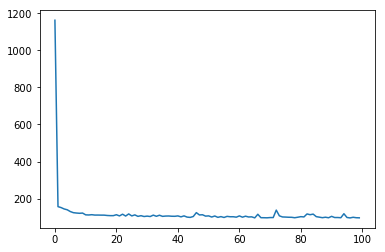

In [126]:
ann = ANN(hidden_layer_sizes=[10])
ann.fit(X=X_train,y=y_train)

In [127]:
print ann.score(X_test,y_testO)

[array([6, 2, 7, ..., 3, 1, 6], dtype=int64)]
0.930375180375
